In [42]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans

# Clean Tensor from Separate Data
Using Tensor constructed from separate data without anomaly injections

In [38]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


/var/folders/80/w14y6f9s2_g49cyn7jpfhrfh0000gn/T/ipykernel_47718/621034405.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Text(0, 0.5, 'Frequency')

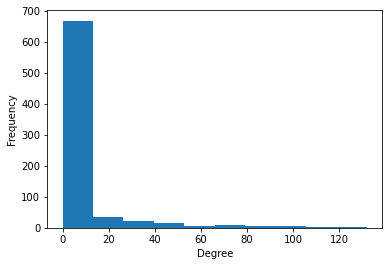

In [39]:
plt.hist(nx.degree_histogram(G))
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [40]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [ ]:
G, ego_gs, _ = load_bc_data(G)

In [ ]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [ ]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

In [ ]:
with open('decomp.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()

In [ ]:
core, factors = result

In [ ]:
A, B, C = factors

In [ ]:
A, B, C, = np.array(A), np.array(B), np.array(C)

In [ ]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

In [ ]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

In [ ]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

In [ ]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

In [ ]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

In [ ]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

In [ ]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [ ]:
comb = [results_clean, results_anom]

In [ ]:
plt.boxplot(comb)

In [ ]:
# using non-anomolous nodes from original data (no anomalies)

with open('egonets.sav', 'rb') as f:
    ego_gs = pickle.load(f)
    f.close()

print(f'Using {len(ego_gs)} egonets')

In [ ]:
indices = np.random.randint(0, len(anom_gs), size=len(clean_gs))

sampled_anoms = np.array(anom_gs, dtype=object)[indices]

In [ ]:
padded_anom = []
for gs in tqdm(sampled_anoms):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

In [ ]:
results_anom = []
indices = np.random.randint(0, len(padded_anom), size=len(padded_clean))
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
anom_y = np.zeros(len(results_anom))

In [ ]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

## Redefine Anomalies
Redefining anomalies egonets as egonets with root node as anomalous

In [ ]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

In [ ]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []
    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, max_graph, roots

In [ ]:
G, ego_gs, _, roots = load_bc_data(G)

In [ ]:
roots = [int(r) for r in roots]

In [ ]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

In [ ]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

In [ ]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

In [ ]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

In [ ]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

In [ ]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')

plt.legend(['Anom', 'Clean'])

In [ ]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [ ]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# Clean tensor with modified data
Using "clean" tensor from redefined clean egonets. 

See BC_EgoNet_Tensor.ipynb for details. 

In [45]:
with open('decomp_mod.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

## Original Anomaly Definition

In [46]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [47]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [48]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [49]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [50]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [51]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [52]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [53]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [54]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [55]:
# storing results
saved_model = open('rec_error_clean.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [56]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

149.8612272252934 4.203161302021947
27.92187479154074 2.1179947797423204


In [57]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

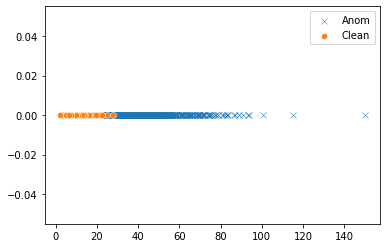

In [58]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

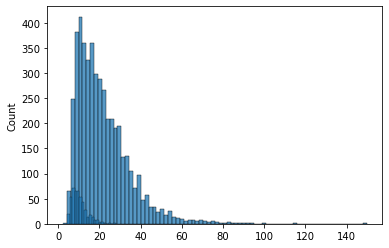

In [59]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7aab9b2430>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7aab9b2a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7aab9b2160>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7aab9b2f70>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7ab8b35280>,
 'means': []}

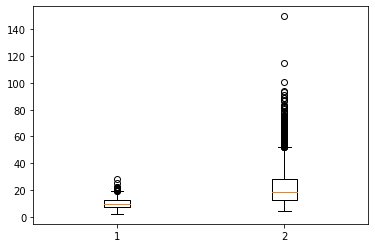

In [60]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [61]:
with open('rec_error_clean.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [62]:
results = []
results.extend(results_anom); results.extend(results_clean)

In [63]:
results = np.array(results).reshape(-1, 1)
np.random.shuffle(results)

results

array([[24.29481572],
       [15.50807845],
       [18.4074689 ],
       ...,
       [ 9.40852423],
       [28.60743207],
       [38.01458472]])

In [64]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

<AxesSubplot:>

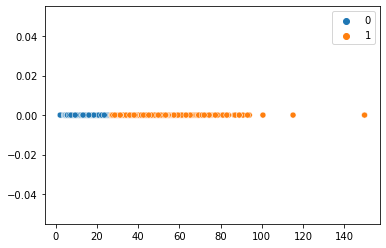

In [65]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)

## Redefined Anomalies

In [67]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


/var/folders/80/w14y6f9s2_g49cyn7jpfhrfh0000gn/T/ipykernel_47718/621034405.py:5: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [68]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [69]:
G, ego_gs, roots = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [70]:
roots = [int(r) for r in roots]

In [71]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [72]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/298 [00:00<?, ?it/s]

In [73]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [74]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/298 [00:00<?, ?it/s]

In [75]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [76]:
# storing results
saved_model = open('rec_error_clean_mod.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom_mod.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [77]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

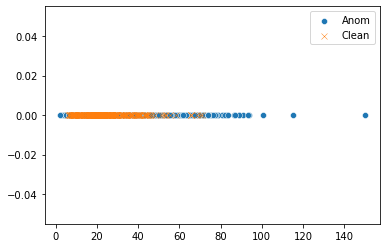

In [78]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

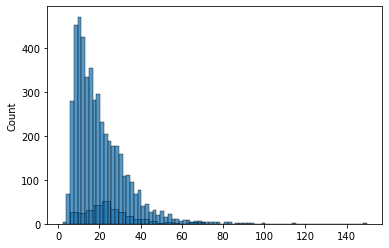

In [79]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7aab798d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7aab7b5310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7aab798a60>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7aab7b58b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7aab7b5b80>,
 'means': []}

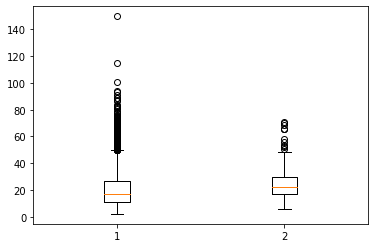

In [80]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [81]:
with open('rec_error_clean_mod.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom_mod.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [82]:
results = []
results.extend(results_anom); results.extend(results_clean)

In [83]:
results = np.array(results).reshape(-1, 1)
np.random.shuffle(results)

results

array([[20.97722076],
       [34.42531843],
       [13.23615905],
       ...,
       [19.77623717],
       [ 9.20028763],
       [10.66575473]])

In [84]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

<AxesSubplot:>

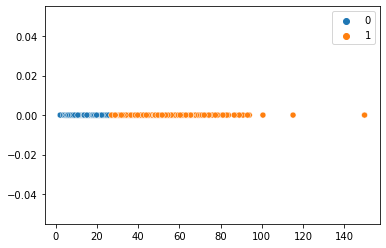

In [85]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)